# Societe Generale Stock Return Prediction

In this project, we will use different supervised learning-based models to predict the returns of Societe Generale Cote d'Ivoire using correlated stocks and its own historical data.

# Content

* [1. Problem Definition](#0)
* [2. Load the Python librairies and Data](#1)
    * [2.1 Load Libraries](#1.1)    
    * [2.2 Load Data](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2 Data Visualisation](#2.2)
    * [3.3 Times Series Analysis](#2.2)
* [4. Data Preparation](#3) 
* [5. Evaluate Algorithms and Models](#4)        
    * [5.1 Train Test Split](#4.1)
    * [5.2 ARIMA Train Test Split](#4.2)
    * [5.3 LSTM Train Test Split](#4.3)
* [6. Grid search and Model Tuning](#5)
* [7. Finalise the Model](#6)
    * [7.1. Results on Test Data](#6.1)
    * [7.2. Save Model for Later Use](#6.2)
    * [7.3. Actual vs Predicted Graph Comparison](#6.1)
 * [7. Finalise the Model](#6)

# 1. Problem Definition

We will use Societe Generale's weekly yield as the predictor variable. It's important to understand what affects the company's price in the regional market, as it is one of the drivers.

For this project, other than the historical data of Societe Generale, the independent variables used are the regional market index for financial firms, which is BRVMFI, some peers in terms of market capitalisation, which are :
* Ecobank Cote d'Ivoire (ECOC);
* Coris Bank International Burkina Faso (CBIBF);
* Societe Ivoirienne de Banque (SIBC)

 # 2. Loading the Python Packages and Data

## 2.1 Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 2.2 Loading the data

We extracted the data using R, cleaned it in Excel and then uploaded it using pandas.

In [20]:
# Export data
SGBC = pd.read_excel(r'E:\Documents\Work\Personal_Projects\ARIMAX_SGBC\SGBC.xlsx').set_index("Date")
BRVMFI = pd.read_excel(r'E:\Documents\Work\Personal_Projects\ARIMAX_SGBC\BRVMFI.xlsx').set_index("Date")
SIBC = pd.read_excel(r'E:\Documents\Work\Personal_Projects\ARIMAX_SGBC\SIBC.xlsx').set_index("Date")
CBIBF = pd.read_excel(r'E:\Documents\Work\Personal_Projects\ARIMAX_SGBC\CBIBF.xlsx').set_index("Date")
ECOC = pd.read_excel(r'E:\Documents\Work\Personal_Projects\ARIMAX_SGBC\ECOC.xlsx').set_index("Date")

Since we dicided to predict the weekly returns, the appropriate period will be 5.

In [6]:
return_period = 5

We now define our Y and X series

Y: SGBC **Future** Returns

X:

    a. BRVMFI 5 Business Day Returns
    b. ECOC 5 Business Day Returns
    c. SIBC 5 Business Day Returns
    d. CBIBF 5 Business Day Returns
    e. SGBC 5 Business Day Returns    
    f. SGBC 15 Business Day Returns    
    g. SGBC 30 Business Day Returns    
    h. SGBC 60 Business Day Returns

In [21]:
# Naming
SGBC.name = 'SGBC'
BRVMFI.name = 'BRVMFI'
SIBC.name = 'SIBC'
CBIBF.name = 'CBIBF'
ECOC.name = 'ECOC'

In [22]:
Y = np.log(SGBC['Close']).diff(return_period).shift(-return_period)
Y.name = SGBC.name+'_pred'

X1 = np.log(BRVMFI['Close']).diff(return_period)
X1.name = BRVMFI.name

X2 = np.log(SIBC['Close']).diff(return_period)
X2.name = SIBC.name

X3 = np.log(CBIBF['Close']).diff(return_period)
X3.name = CBIBF.name

X4 = np.log(ECOC['Close']).diff(return_period)
X4.name = ECOC.name

X5 = pd.concat([np.log(SGBC['Close']).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X5.columns = ['SGBC_DT', 'SGBC_3DT', 'SGBC_6DT', 'SGBC_12DT']

X = pd.concat([X1, X2, X3, X4, X5], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period,:]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

 # 3. Exploratory Data Analysis

## 3.1 Descriptive Statistics

Let's see how the data are looking

In [23]:
pd.set_option('display.precision', 3)
dataset.describe()

,SGBC_pred,BRVMFI,SIBC,CBIBF,ECOC,SGBC_DT,SGBC_3DT,SGBC_6DT,SGBC_12DT
count,198.000,1.980e+02,198.000,198.000,198.000,198.000,1.980e+02,198.000,198.000
mean,0.003,9.829e-04,0.003,-0.008,0.003,0.005,1.040e-02,0.020,0.040
std,0.038,4.460e-02,0.029,0.114,0.048,0.037,6.214e-02,0.085,0.121
min,-0.106,-2.761e-01,-0.118,-1.555,-0.129,-0.105,-2.025e-01,-0.273,-0.348
25%,-0.013,-8.749e-03,-0.011,-0.013,-0.015,-0.014,-2.171e-02,-0.025,-0.038
50%,0.000,1.030e-03,0.002,0.000,0.000,0.000,2.175e-04,0.018,0.051
75%,0.013,1.271e-02,0.020,0.003,0.023,0.013,4.275e-02,0.062,0.117
max,0.251,3.711e-01,0.095,0.113,0.333,0.251,2.585e-01,0.365,0.320


In [24]:
dataset.head()

,SGBC_pred,BRVMFI,SIBC,CBIBF,ECOC,SGBC_DT,SGBC_3DT,SGBC_6DT,SGBC_12DT
Date,,,,,,,,,
2017-12-19,-8.299e-03,0.045,0.006,-1.555,0.333,4.351e-04,4.351e-04,0.044,0.017
2017-12-27,1.696e-02,0.009,0.061,0.051,-0.069,-8.299e-03,-5.249e-03,-0.009,0.009
2018-01-04,-4.313e-04,-0.009,-0.009,-0.025,-0.094,1.696e-02,9.097e-03,-0.026,0.053
2018-01-11,-1.697e-02,-0.018,-0.021,-0.058,-0.098,-4.313e-04,8.230e-03,0.009,0.043
2018-01-18,4.387e-04,-0.009,0.024,-0.021,0.038,-1.697e-02,-4.387e-04,-0.006,0.035


## 3.2 Data Visualisation

Let's now have a look at the distribution of the data over the period

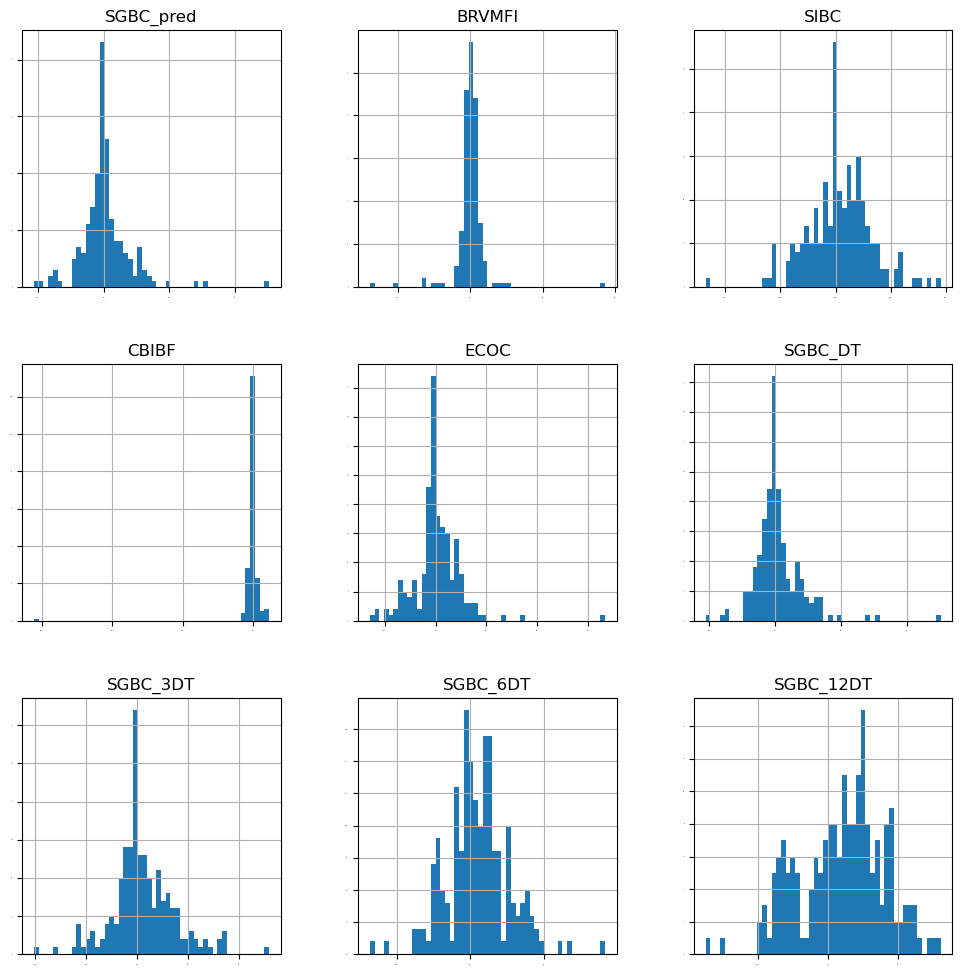

In [25]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

These are the histograms of the distribution for each series individually. Thus, we proceed to look at the density distribution.

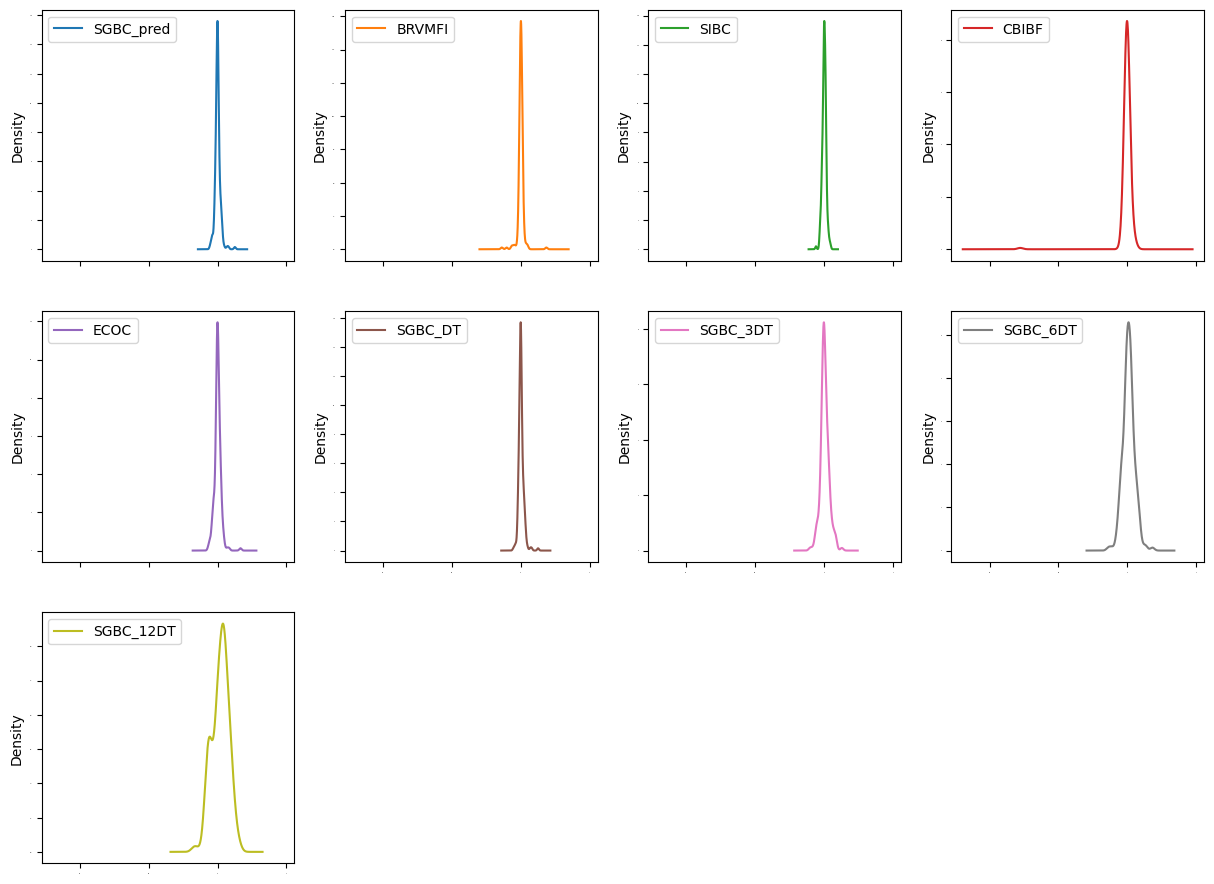

In [26]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We could notice a larger variance of CBIBF among the peers and the lagged 30 days return of SGBC among the lagged variable as well as generally.

We will now have a look at the scatter plot and the correlation matrix to get a sense of existing interdependance.

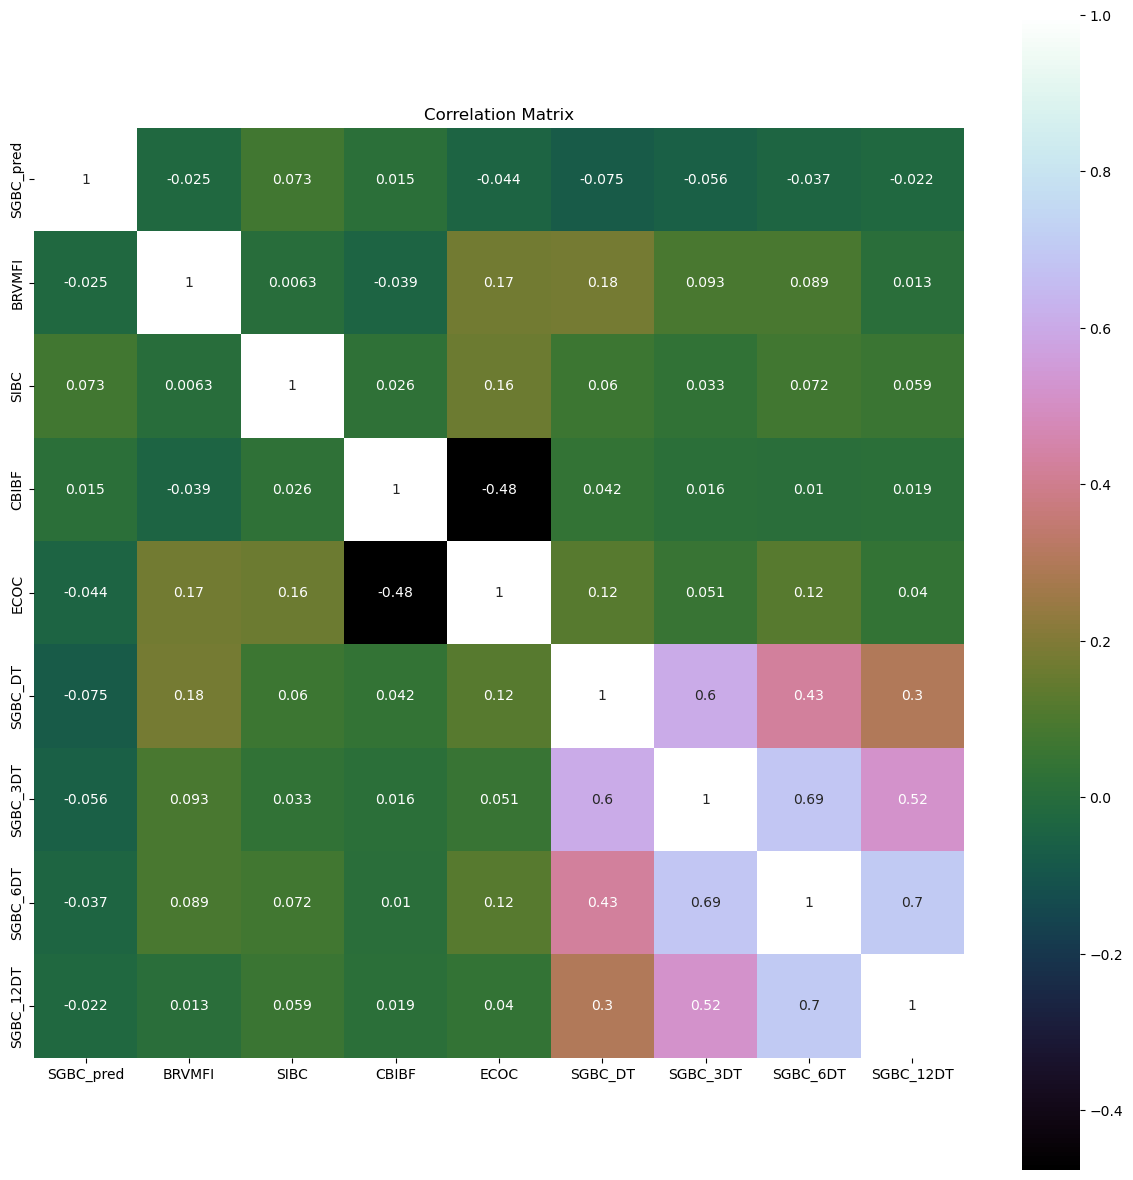

In [27]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix');

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days return of SGBC. 

<Figure size 1500x1500 with 0 Axes>

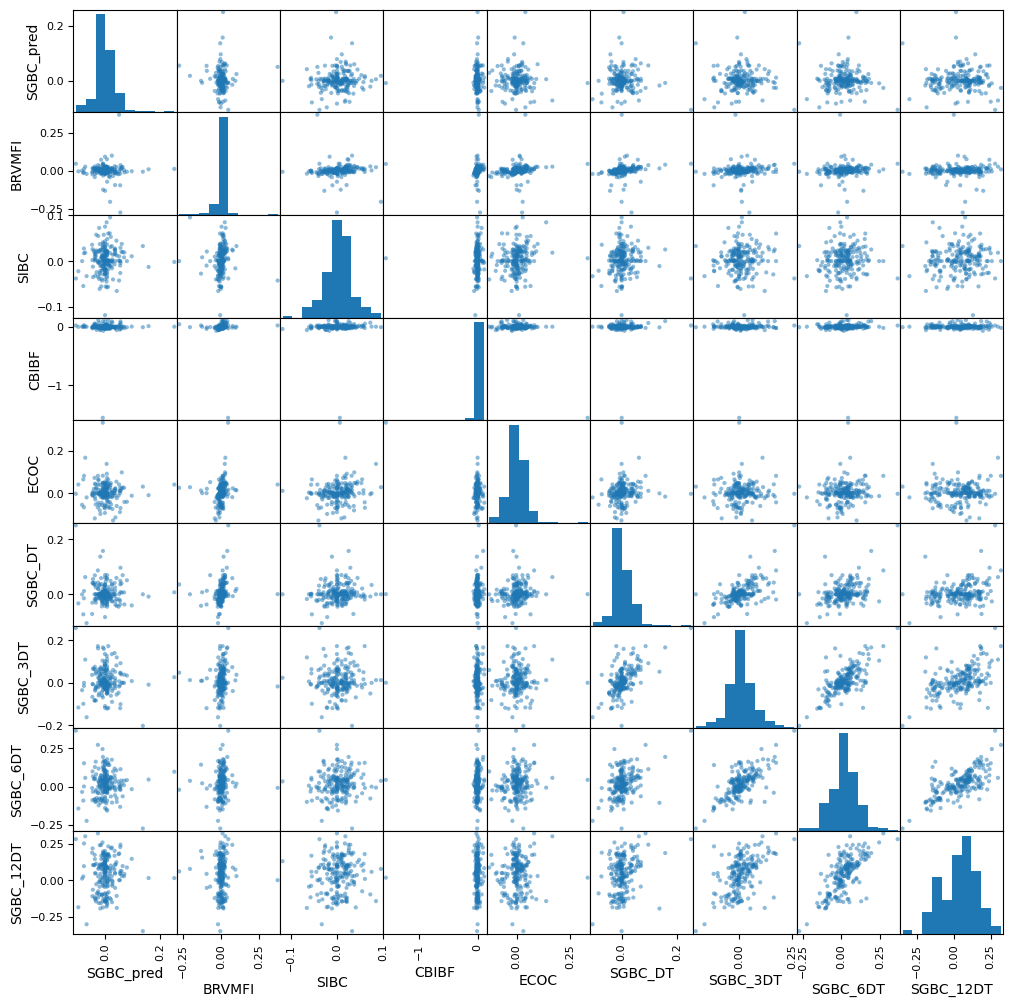

In [28]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show();

Looking at the scatter plot above, we see some linear relationship of the predicted variable with the lagged 5 days, 30 days and 60 days return of SGBC as well as BRMFI .

## 3.3 Times Series Analysis

Next, we look at the seasonal decomposition of our time series

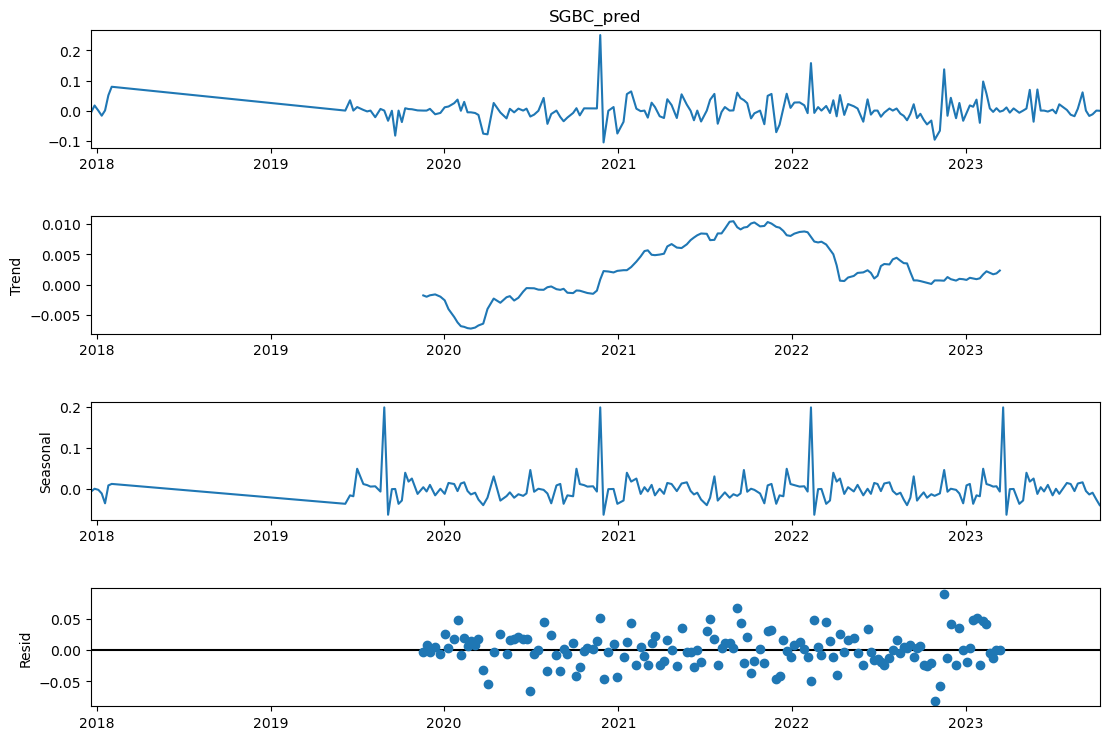

In [29]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
pyplot.show()

The gap between 2018 and 2020 can be attributed to the IPOs of peers during that period. It is worth noting that there has been a general upward trend observed for SGBC.

# 4. Data Preparation

The sklearn's SelectKBest  function is used to get a sense of feature importance. 

In [80]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores

,Specs,Score
0,BRVMFI,0.126
1,SIBC,1.038
2,CBIBF,0.047
3,ECOC,0.374
4,SGBC_DT,1.095
5,SGBC_3DT,0.615
6,SGBC_6DT,0.266
7,SGBC_12DT,0.095


Seemingly, SGBC_DT holds the highest importance while CBIBF has the least significance.

# 5. Evaluate Algorithms and Models

## 5.1 Train Test Split

Since a Time series models will be used, we split the data in continous series.

In [31]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

## 5.2 ARIMA Train Test Split

Let us now prepare the dataset for ARIMA models by only using correlated variables as exogenous variables.

In [32]:
X_train_ARIMA=X_train.loc[:, ['BRVMFI', 'SIBC', 'CBIBF', 'ECOC']]
X_test_ARIMA=X_test.loc[:, ['BRVMFI', 'SIBC', 'CBIBF', 'ECOC']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [33]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [34]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0008385809957697887

## 5.3 LSTM Model Train Test Split

In [35]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [38]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

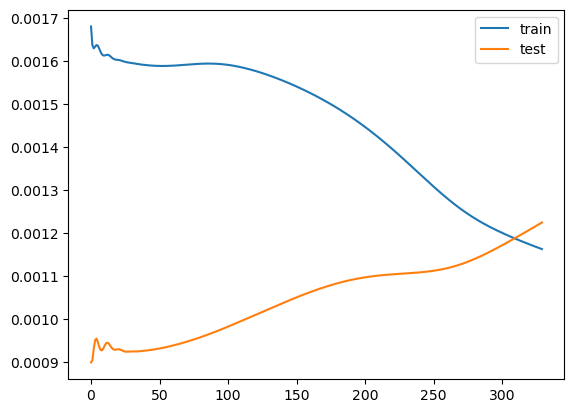

In [39]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

2/2 [==============================] - 0s 2ms/step


## Models Comparison

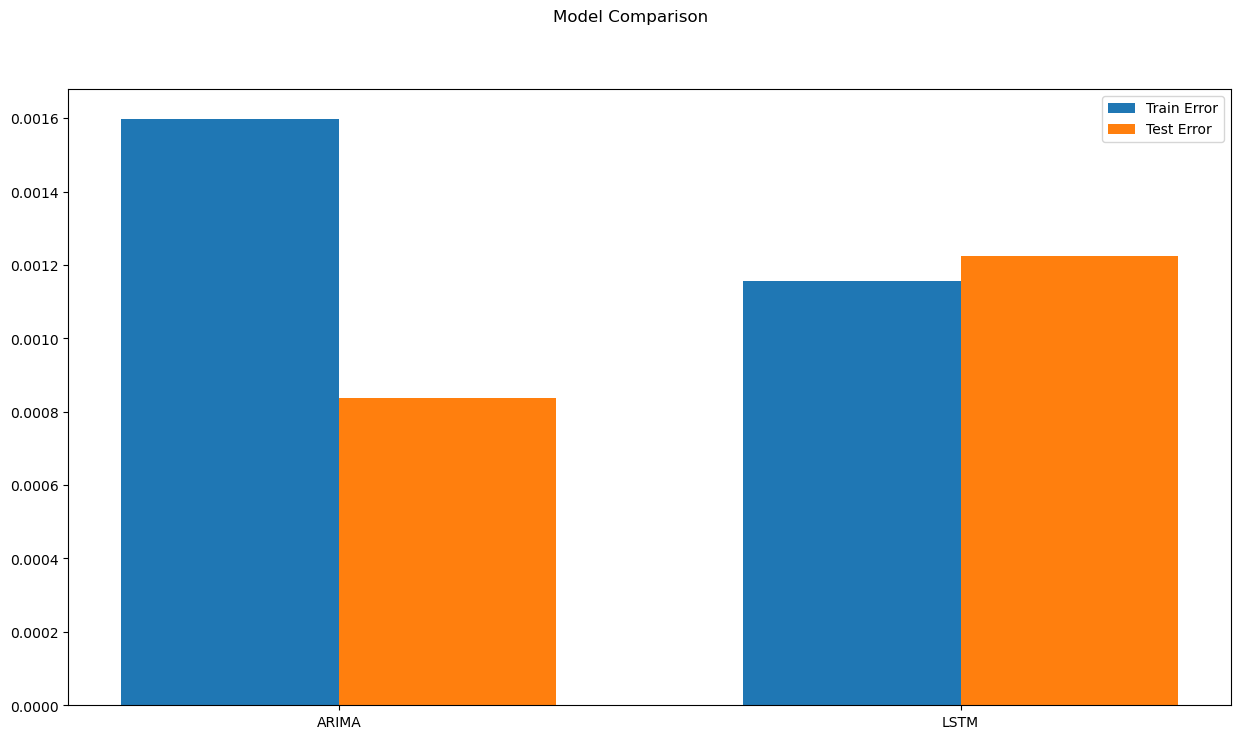

In [41]:
names = ["ARIMA", "LSTM"]
test_results = [error_Test_ARIMA, error_Test_LSTM]
train_results = [error_Training_ARIMA, error_Training_LSTM]

# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Although ARIMA's training error is highest, the model attains a lower test error in comparison to the LSTM model.

# 6. Grid Search and Model Tuning

Based on the previous chart, the ARIMA model is deemed the most suitable. Thus, to enhance the model performance, we require a model tuning process. To accomplish this, we perform a grid search utilizing various combinations of p, d and q, which constitute the parameters of the model. 

In [42]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0016018
ARIMA(0, 0, 1) MSE=0.0015986
ARIMA(0, 1, 0) MSE=0.0032446
ARIMA(0, 1, 1) MSE=0.0016360
ARIMA(1, 0, 0) MSE=0.0015987
ARIMA(1, 0, 1) MSE=0.0016000
ARIMA(1, 1, 0) MSE=0.0024436
ARIMA(1, 1, 1) MSE=0.0016704
ARIMA(2, 0, 0) MSE=0.0015978
ARIMA(2, 0, 1) MSE=0.0015979
ARIMA(2, 1, 0) MSE=0.0020466
ARIMA(2, 1, 1) MSE=0.0016351
Best ARIMA(2, 0, 0) MSE=0.0015978


# 7. Finalise The Model

## 7.1 Result on Test Data

In [76]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,0])
model_fit_tuned = modelARIMA_tuned.fit()

In [44]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0008385809957697887


After selecting and tuning the optimal ARIMA model (2, 0, 0), we have chosen this model for use in our modelling purposes.

## 7.2 Model Saving

In [ ]:
from pickle import dump
from pickle import load
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

## 7.3 Actual vs Predicted Comparison

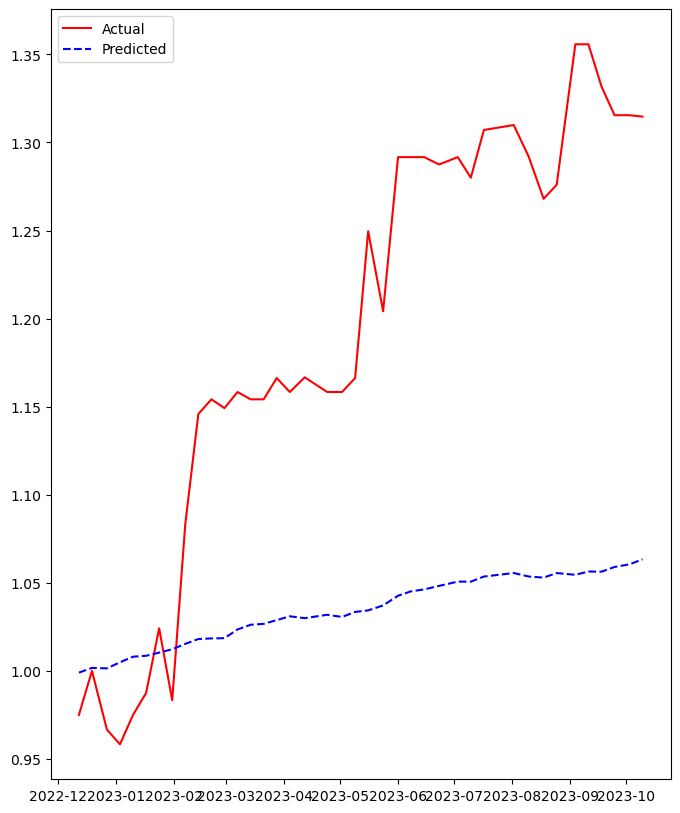

In [84]:
# Actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r')
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--')
pyplot.rcParams["figure.figsize"] = (8,9)
pyplot.legend(["Actual", "Predicted"], loc ="upper left");
pyplot.show()

## Summary and Conclusion

Upon reviewing the chart, it becomes apparent that the model has accurately captured the general trend. The predicted series exhibits lower volatility when compared to the actual time series. It is worth noting that the model is designed to calculate the return for the following day, based on the data observed up to the present day. It is not intended to predict the future stock price over several days based on current data. Therefore, it is expected to deviate from the actual data as we progress further into the test set.